In [133]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [134]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn

In [69]:
class SkinIrritationNN(nn.Module):
    def __init__(self, input_dim):
        super(SkinIrritationNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),

            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0-1
        )

    def forward(self, x):
        return self.model(x)

In [5]:
class EnsembleModel:
    def __init__(self, model_filenames):
        self.model_filenames = model_filenames
        self.models = [joblib.load(model_file) for model_file in model_filenames]
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.array([Counter(predictions[:, i]).most_common(1)[0][0] for i in range(predictions.shape[1])])
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y) * 100
        return accuracy

In [135]:
file_path = '../Features/Large/selected_features_CorrVar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,0,0.545511,0.223433,0.490223,0.390551,0.291325,0.250000,0.472316,0.592036,-1.017995,...,0.447214,0.451534,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
1,1,0.591920,0.253125,0.601726,0.389406,0.277681,0.278846,0.315886,0.215424,1.052267,...,0.447214,0.416318,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
2,1,0.553126,0.334919,0.502072,0.400859,0.399452,0.278846,0.472195,0.592036,-1.018511,...,0.447214,0.475805,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
3,0,0.612445,0.602032,0.496240,0.408749,0.461148,0.423077,0.676377,0.290413,0.491735,...,0.000000,0.560347,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
4,0,0.618170,0.914475,0.141109,0.000000,0.000000,0.000000,0.354992,0.378416,-0.071536,...,0.000000,0.225586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [136]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [137]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 1989 samples
Test set: 498 samples


In [138]:
qsar_model = joblib.load("qsar_model.pkl")
rf_model = joblib.load("rf_model.pkl")
dt_model = joblib.load("dt_model.pkl")
knn_model = joblib.load("knn_model.pkl")
svm_model = joblib.load("svm_model.pkl")
torch_model = torch.load("nn.pth")


In [139]:
def get_pytorch_predictions(model, data, device):
    model.eval()  # Set the model to evaluation mode
    # Convert the pandas DataFrame to a numpy array, then to a tensor
    data = torch.tensor(data.values).float().to(device)  # .values pre prevod DataFrame na numpy array
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(data)  # Get raw predictions (logits)
    return outputs

In [140]:
import pandas as pd

# Get base model predictions (stacking inputs)
stacking_inputs = np.column_stack([
    qsar_model.predict(X_test),
    rf_model.predict(X_test),
    dt_model.predict(X_test),
    knn_model.predict(X_test),
    svm_model.predict(X_test),
])

# Fit a simple Logistic Regression model for interpretability
meta_model = LogisticRegression()
meta_model.fit(stacking_inputs, y_test)

# Check coefficients to see which models contribute most
coefs = pd.DataFrame(meta_model.coef_, columns=["qsar", "rf", "dt", "knn", "svm"])
print(coefs)


       qsar        rf        dt       knn      svm
0  0.703436  1.442808  0.416856  0.418212 -0.18621


In [149]:
# Assuming the PyTorch model is trained and on the same device as your data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_model.to(device)

# Updated stacking inputs (without QSAR)
stacking_inputs = np.column_stack([
    qsar_model.predict(X_test),
    svm_model.predict(X_test),
    rf_model.predict(X_test),
    dt_model.predict(X_test),
    knn_model.predict(X_test),
    #get_pytorch_predictions(torch_model, X_test, device), 
])

# Fit Logistic Regression again
meta_model = LogisticRegression()
meta_model.fit(stacking_inputs, y_test)

# Check new coefficients
coefs = pd.DataFrame(meta_model.coef_, columns=["qsar", "svm", "rf", "dt", "knn"])
print(coefs)


       qsar      svm        rf        dt       knn
0  0.703436 -0.18621  1.442808  0.416856  0.418212


# NN, RF, KNN

In [141]:
# Skús stackovať len s RF, NN, KNN a testuj výkon
stacking_inputs = np.column_stack([
    qsar_model.predict(X_test),
    svm_model.predict(X_test),
    knn_model.predict(X_test),
    get_pytorch_predictions(torch_model, X_test, device), 
])

meta_model.fit(stacking_inputs, y_test)
meta_preds = meta_model.predict(stacking_inputs)
test_accuracy = accuracy_score(y_test, meta_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Perform k-fold cross-validation
cv_scores = cross_val_score(meta_model, stacking_inputs, y_test, cv=5, scoring='accuracy')

# Print mean and standard deviation of cross-validation scores
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")
print(f"Cross-validation standard deviation: {cv_scores.std():.4f}")

Test Accuracy: 0.8213
Cross-validation mean accuracy: 0.8273
Cross-validation standard deviation: 0.0461


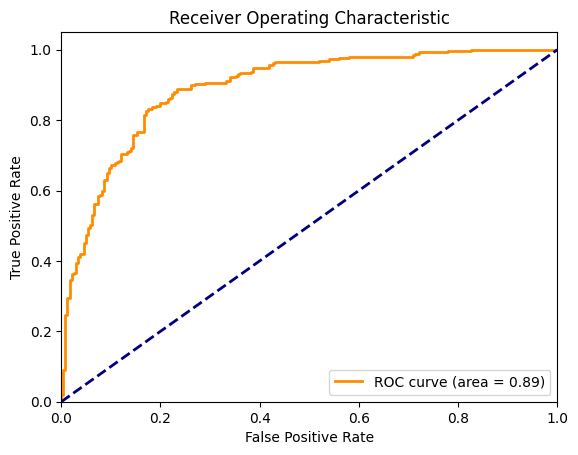

In [142]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for the positive class (1) from the meta_model
# For logistic regression, we use predict_proba to get probabilities
meta_model_prob = meta_model.predict_proba(stacking_inputs)[:, 1]  # Probabilities for class 1

# Compute ROC curve and ROC AUC for the meta-model
fpr, tpr, thresholds = roc_curve(y_test, meta_model_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [146]:
import pandas as pd

# Assuming you already have the predictions for each model
stacking_inputs = np.column_stack([
    qsar_model.predict(X_test),
    svm_model.predict(X_test),
    knn_model.predict(X_test),
    get_pytorch_predictions(torch_model, X_test, device), 
])


# Create a DataFrame with model names as column headers
stacking_inputs_df = pd.DataFrame(stacking_inputs, columns=["QSAR", "SVM", "KNN", "NN"])

# Now we can proceed with SHAP using the updated column names

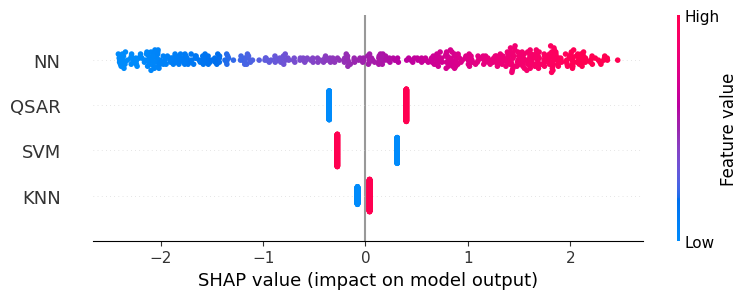

In [147]:
# Create a SHAP explainer for the Logistic Regression model
explainer_meta = shap.Explainer(meta_model, stacking_inputs_df)

# Compute SHAP values for the meta-model
shap_values_meta = explainer_meta(stacking_inputs_df)

# Plot the SHAP summary plot for the meta-model with model names as feature labels
shap.summary_plot(shap_values_meta, stacking_inputs_df)

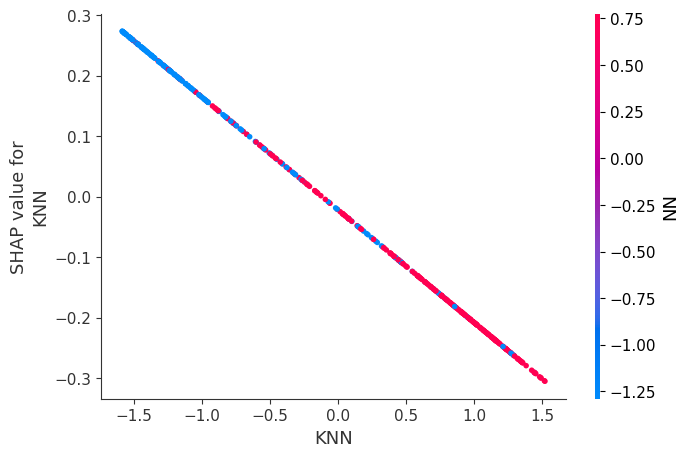

In [106]:
# Convert SHAP values to NumPy array (take `.values` from Explanation object)
shap_values_array = shap_values_meta.values

# Now pass the array instead of Explanation object
shap.dependence_plot("KNN", shap_values_array, stacking_inputs_df)


In [112]:
mean_abs_shap = np.abs(shap_values_meta.values).mean(axis=0)
print("Mean absolute SHAP values:", mean_abs_shap)


Mean absolute SHAP values: [0.55517661 1.36635361]


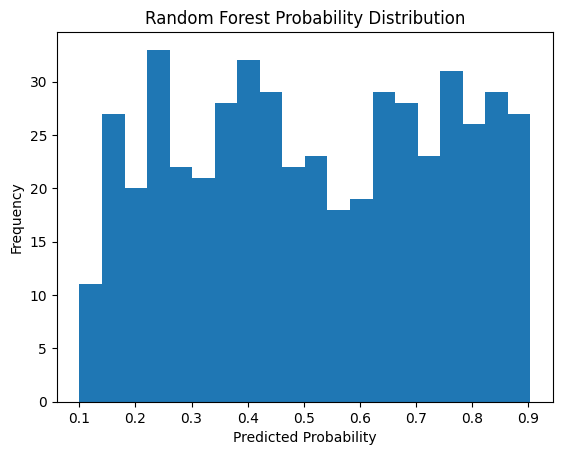

In [113]:
rf_probs = rf_model.predict_proba(X_test)[:, 1]
plt.hist(rf_probs, bins=20)
plt.title("Random Forest Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


# RF, DT, KNN

In [151]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# Get base model predictions on all data for cross-validation
stacking_inputs = np.column_stack([
    qsar_model.predict(X_test),
    rf_model.predict(X_test),
    dt_model.predict(X_test),
    knn_model.predict(X_test),
])

# Initialize and train the meta-model (Logistic Regression)
meta_model = LogisticRegression()

# Perform k-fold cross-validation
cv_scores = cross_val_score(meta_model, stacking_inputs, y_test, cv=5, scoring='accuracy')

# Print mean and standard deviation of cross-validation scores
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")
print(f"Cross-validation standard deviation: {cv_scores.std():.4f}")

Cross-validation mean accuracy: 0.7750
Cross-validation standard deviation: 0.0464


In [153]:
# Step 1: Generate base model predictions on training data (X_train)
stacking_train_inputs = np.column_stack([
    rf_model.predict(X_train),    # Random Forest predictions
    dt_model.predict(X_train),    # Decision Tree predictions
    knn_model.predict(X_train),   # KNN predictions
])

# Step 2: Train the meta-model (Logistic Regression) on the training data predictions
meta_model = LogisticRegression()
meta_model.fit(stacking_train_inputs, y_train)

# Step 3: Generate base model predictions on the test data (X_test)
stacking_inputs_test = np.column_stack([
    rf_model.predict(X_test),    # Random Forest predictions
    dt_model.predict(X_test),    # Decision Tree predictions
    knn_model.predict(X_test),   # KNN predictions
])

# Step 4: Use the trained meta-model to make predictions on the test set
test_preds = meta_model.predict(stacking_inputs_test)

# Step 5: Evaluate the test accuracy
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")



Test Accuracy: 0.7711
